In [33]:
import os
import glob 
import cv2
import pickle
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import numpy as np
print ("The current directory is %s", os.getcwd())

The current directory is %s c:\code\CarND-Advanced-Lane-Lines


10.0


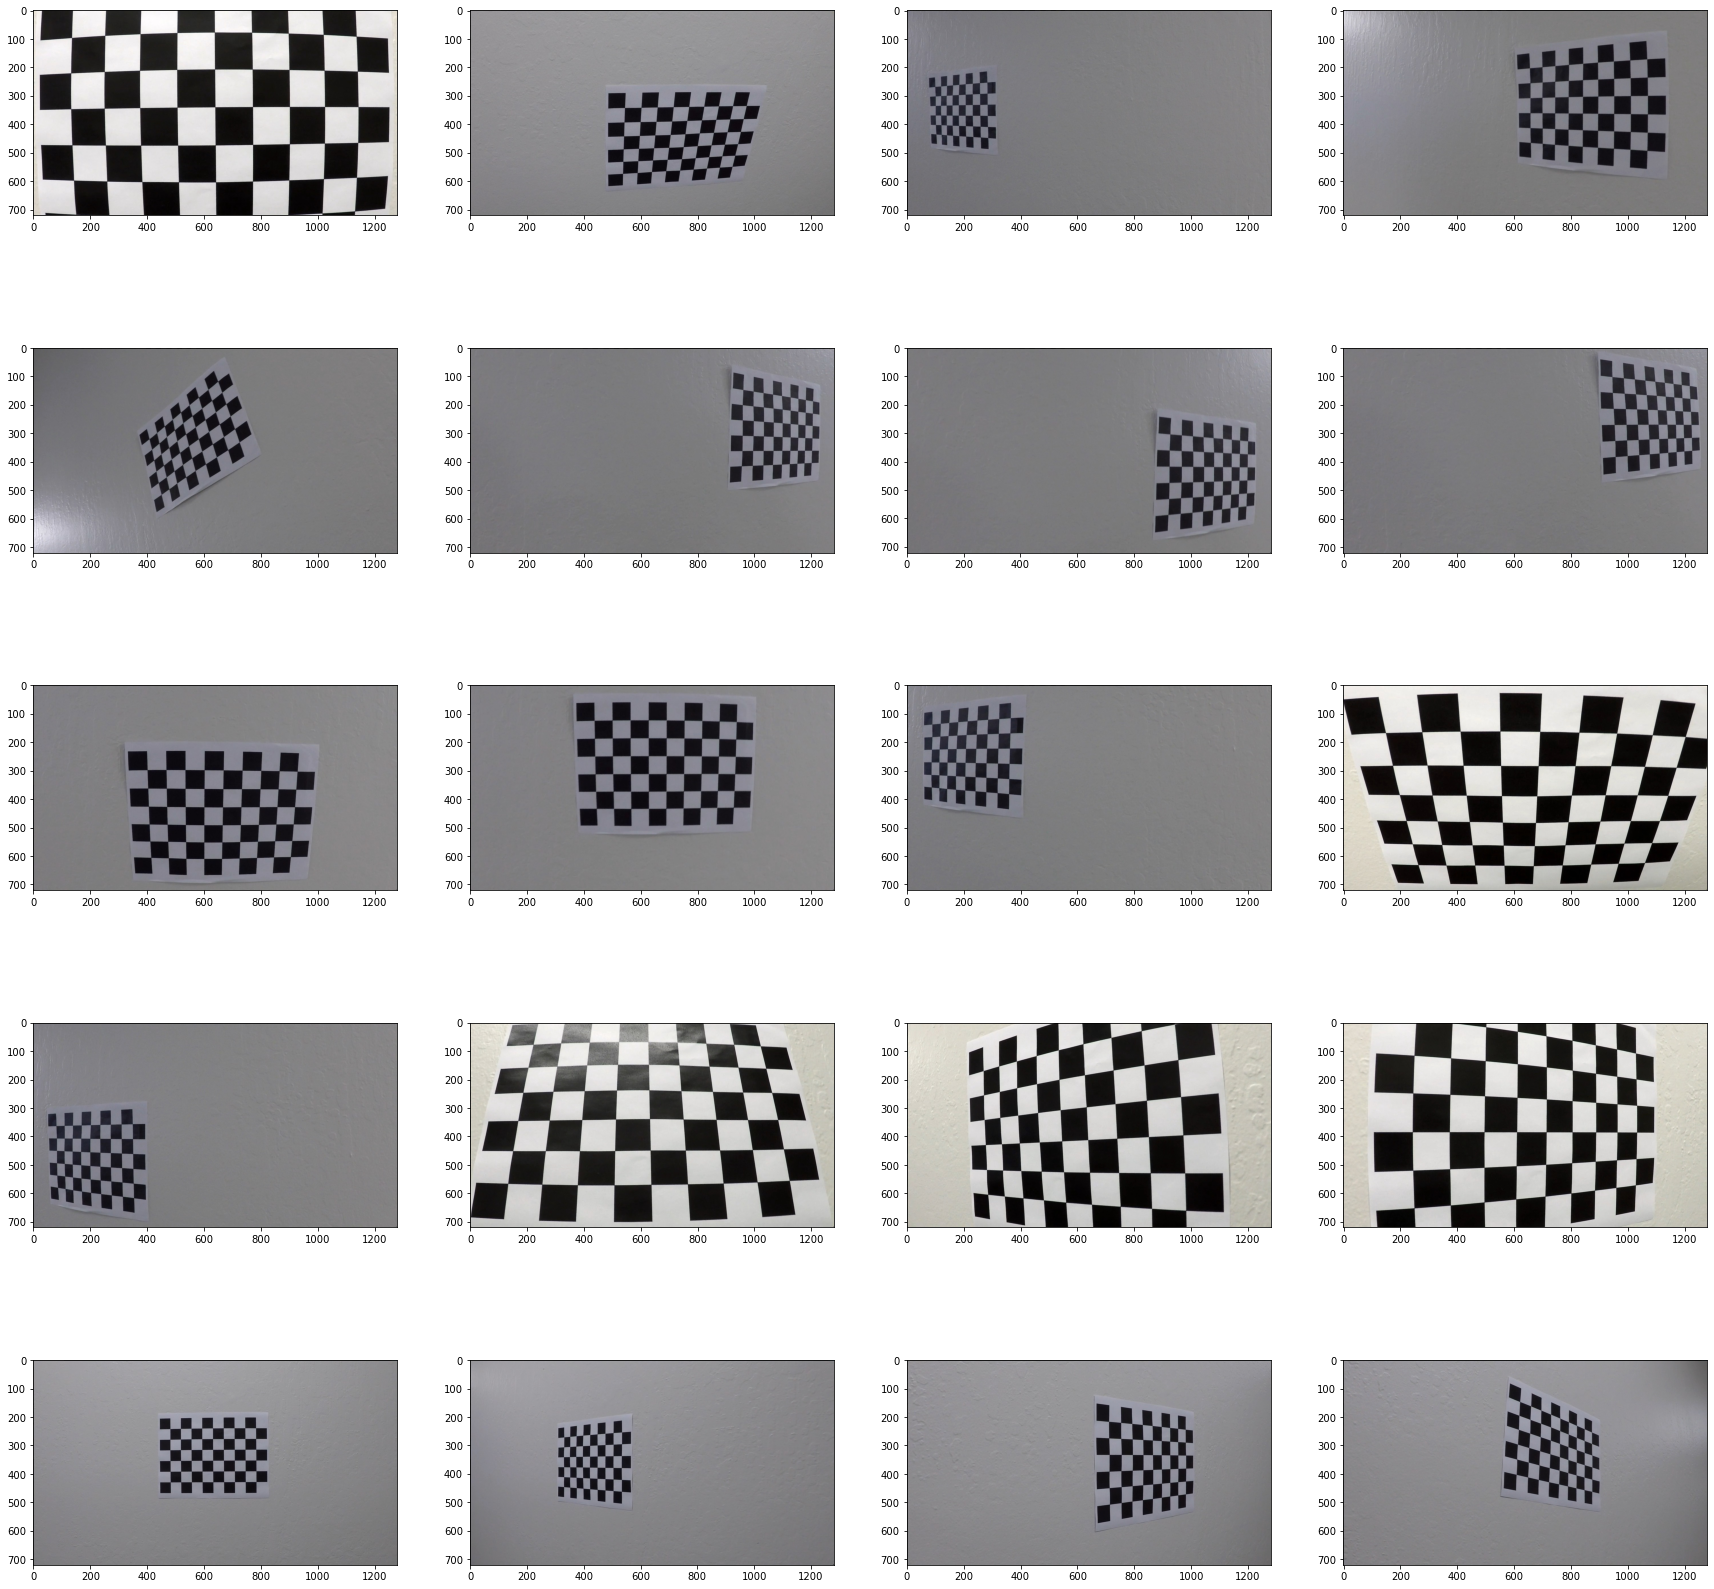

In [34]:
camera_calibration_images = [mpimg.imread(path) for path in glob.glob("camera_cal/*")]
print(len(camera_calibration_images)/2)
fig = plt.figure(figsize=(30,30))
rows = 5
columns = int(len(camera_calibration_images)/rows)
for i in range(len(camera_calibration_images)):
    fig.add_subplot(rows, columns, i+1)
    plt.imshow(camera_calibration_images[i])

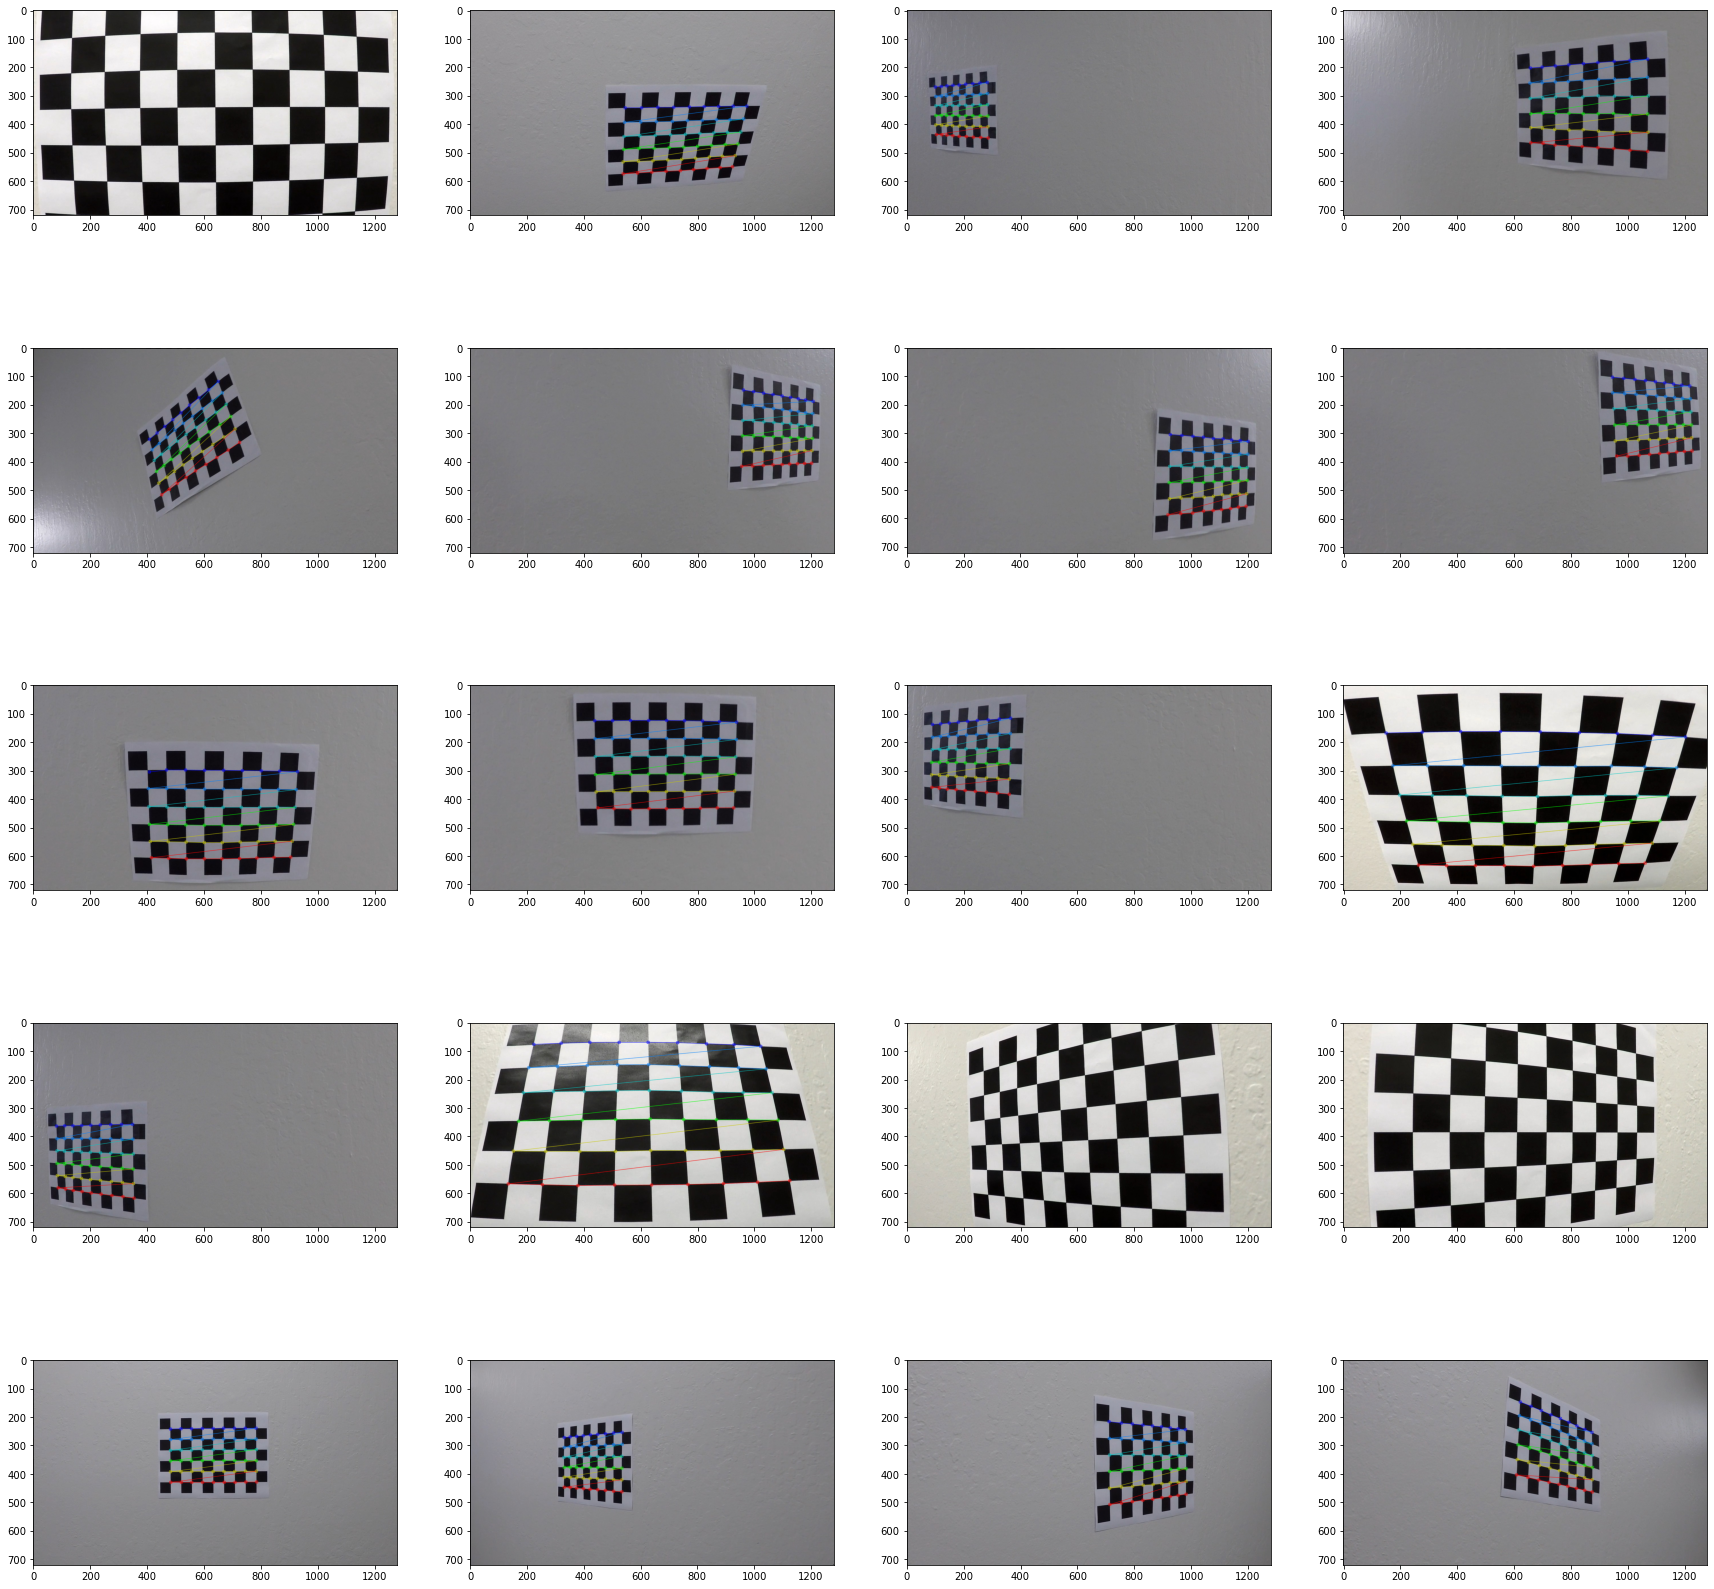

In [35]:
# prepare objects points
objp = np.zeros((6*9, 3), np.float32)
objp[:,:2] = np.mgrid[0:9, 0:6].T.reshape(-1,2)

# Arrays to store object points and iamg points from all the images
objpoints = []
imgpoints = []

def draw_chessboard_image(img):
    gray_img = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    ret, corners = cv2.findChessboardCorners(gray_img, (9,6), None)
    if ret:
        objpoints.append(objp)
        imgpoints.append(corners)
        cv2.drawChessboardCorners(img, (9,6), corners, ret)
    return img

fig = plt.figure(figsize=(30,30))
for i in range(len(camera_calibration_images)):
    img = draw_chessboard_image(camera_calibration_images[i])
    fig.add_subplot(rows,columns, i+1)
    plt.imshow(img)
    


(720, 1280)


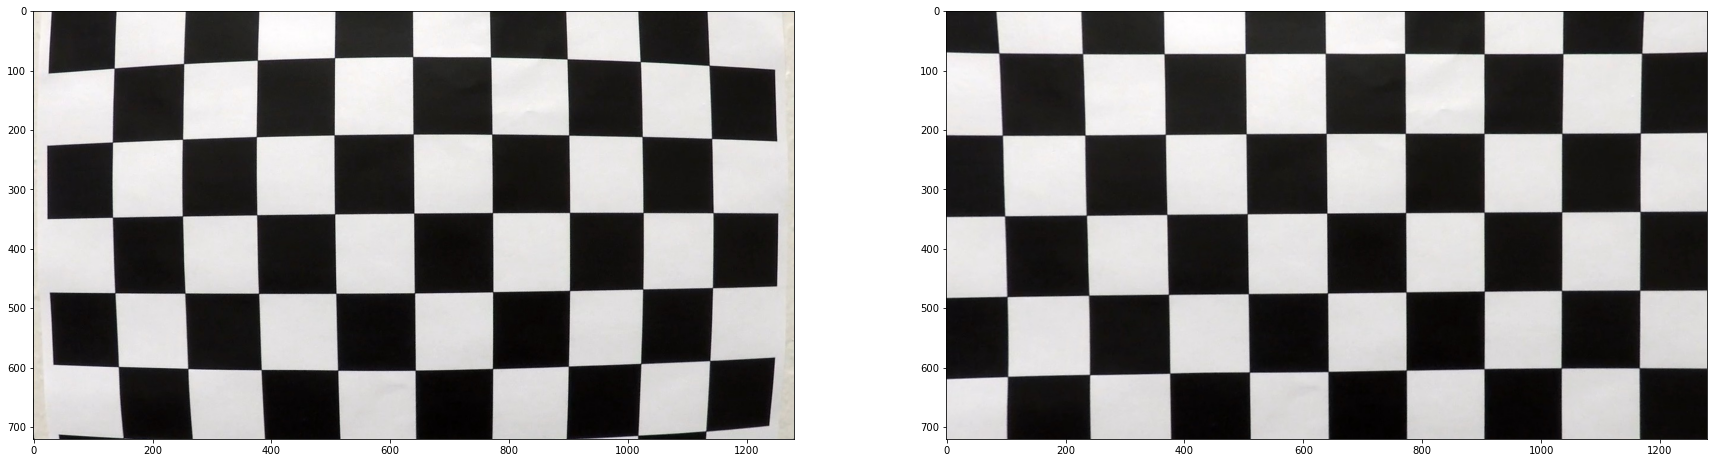

In [36]:

test_img = mpimg.imread("camera_cal/calibration1.jpg")
img_size = test_img.shape[:2]
print(img_size)
ret, mtx, dist, rvecs, tvecs = cv2.calibrateCamera(objpoints, imgpoints,img_size, None, None)
undistorted_img = cv2.undistort(test_img, mtx, dist, None, mtx)
rows = 1
columns = 2
fig = plt.figure(figsize=(30,30))
fig.add_subplot(rows, columns, 1)
plt.imshow(test_img)
fig.add_subplot(rows, columns, 2)
plt.imshow(undistorted_img)

In [37]:
test_images = [mpimg.imread(img) for img in glob.glob("test_images/*")]
height, width = test_images[0].shape[:2]
point1 = (575, 465)
point2 = (705, 465)
point3 = (255, 685)
point4 = (1050, 685)
transform_point1 = (450, 0)
transform_point2 = (width - 450, 0)
transform_point3 = (450, height)
transform_point4 = (width - 450, height)

source = np.float32([point1, point2, point3, point4])
destination = np.float32([transform_point1, transform_point2, transform_point3, transform_point4])


def warp(img):
    undistorted_img = cv2.undistort(img, mtx, dist, None, mtx)
    height,width = undistorted_img.shape[:2]
    transform_matrix = cv2.getPerspectiveTransform(source, destination)
    inverse_transform_matrix = cv2.getPerspectiveTransform(destination, source)
    unwarped_img = cv2.warpPerspective(undistorted_img, transform_matrix, (width, height), flags=cv2.INTER_LINEAR)
    
    hls = cv2.cvtColor(unwarped_img, cv2.COLOR_RGB2HLS)
    l_channel = hls[:,:,1]
    l_channel_normalized = l_channel*(255/np.max(l_channel))
    binary = np.zeros_like(l_channel_normalized)
    binary[(l_channel_normalized > 220)  & (l_channel_normalized <= 255)] = 1
    hls = np.copy(binary)
    
    lab = cv2.cvtColor(unwarped_img, cv2.COLOR_RGB2LAB)
    b_channel = lab[:,:,2]
    b_channel_normalized = b_channel
    if np.max(b_channel) > 175:
        b_channel_normalized = b_channel*(255/np.max(b_channel))
    binary = np.zeros_like(b_channel_normalized)
    binary[(b_channel_normalized > 190) & (b_channel_normalized <= 255)] = 1
    lab = np.copy(binary)
    
    binary = np.zeros_like(lab)
    binary[(hls == 1) | (lab == 1)] = 1
    processed = np.copy(binary)
    return processed,inverse_transform_matrix
    
    

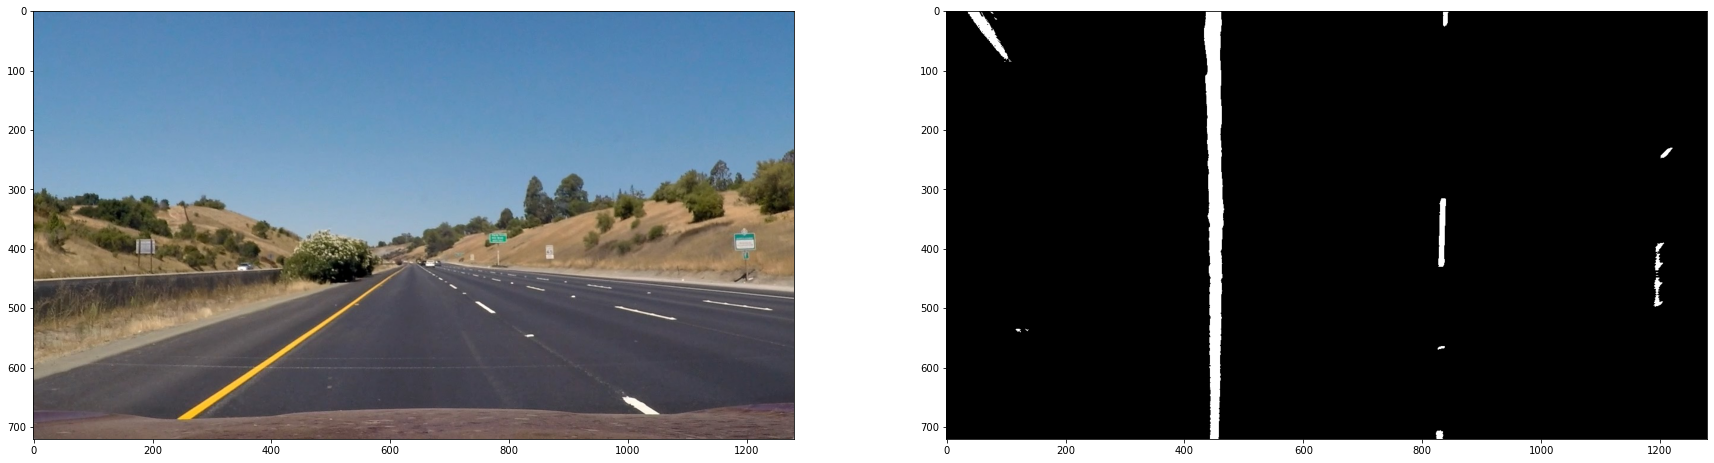

In [38]:
rows = 1
columns = 2
fig = plt.figure(figsize=(30,30))
fig.add_subplot(rows, columns, 1)
plt.imshow(test_images[0])
fig.add_subplot(rows, columns, 2)
war_img,_ = warp(test_images[0]);
plt.imshow(war_img, cmap='gray')

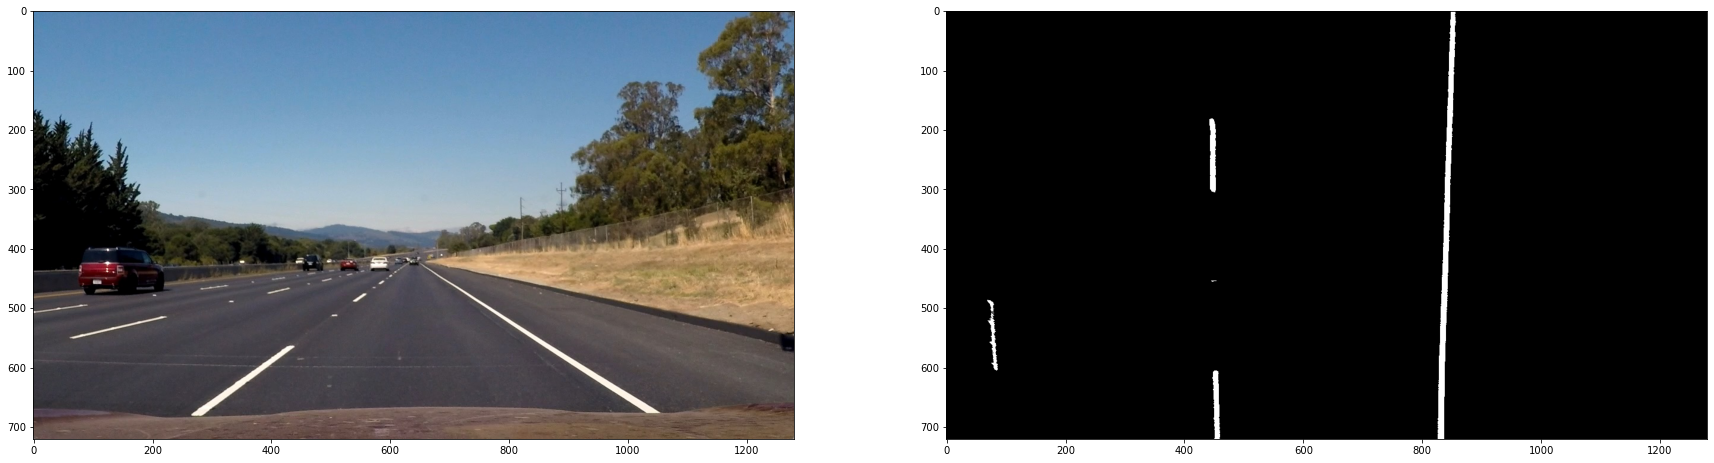

In [39]:
rows = 1
columns = 2
fig = plt.figure(figsize=(30,30))
fig.add_subplot(rows, columns, 1)
plt.imshow(test_images[1])
fig.add_subplot(rows, columns, 2)
war_img,_ = warp(test_images[1])
plt.imshow(war_img, cmap='gray')

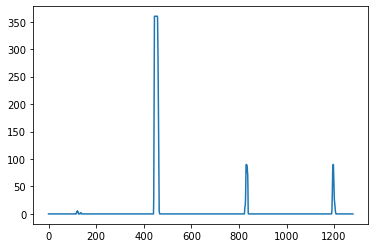

In [40]:
def histogr(img):
    temp = img[img.shape[0]//2:,:]
    return np.sum(temp, axis=0)
war_img,_ = warp(test_images[0])
hist = histogr(war_img)
plt.plot(hist)

In [41]:
print(hist)

[0. 0. 0. ... 0. 0. 0.]


In [42]:
def polygon_interpolation(img):
    
    binary_image, inverse_transform = warp(img) 
    left_fit,right_fit,_,_ = sliding_window(binary_image)
    
    new_img = np.copy(img)
    if left_fit is None or right_fit is None:
        return img
    zero = np.zeros_like(binary_image).astype(np.uint8)
    color = np.dstack((zero, zero, zero))
    
    h,w = binary_image.shape
    ploty = np.linspace(0, h-1, num=h)
    left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
    right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]

    pts_left = np.array([np.transpose(np.vstack([left_fitx, ploty]))])
    pts_right = np.array([np.flipud(np.transpose(np.vstack([right_fitx, ploty])))])
    pts = np.hstack((pts_left, pts_right))

    cv2.fillPoly(color, np.int_([pts]), (0,255, 0))
    cv2.polylines(color, np.int32([pts_left]), isClosed=False, color=(255,0,255), thickness=15)
    cv2.polylines(color, np.int32([pts_right]), isClosed=False, color=(0,255,255), thickness=15)

    newwarp = cv2.warpPerspective(color, inverse_transform, (w, h)) 
    result = cv2.addWeighted(new_img, 1, newwarp, 0.5, 0)
    return result

In [43]:
def embed_info(original_img, curv_rad, center_dist):

    new_img = np.copy(original_img)
    h = new_img.shape[0]
    font = cv2.FONT_HERSHEY_DUPLEX
    text = 'Curve radius: ' + '{:04.2f}'.format(curv_rad) + 'm'
    cv2.putText(new_img, text, (40,70), font, 1.5, (200,255,155), 2, cv2.LINE_AA)
    direction = ''
    if center_dist > 0:
        direction = 'right'
    elif center_dist < 0:
        direction = 'left'
    abs_center_dist = abs(center_dist)
    text = '{:04.3f}'.format(abs_center_dist) + 'm ' + direction + ' of center'
    cv2.putText(new_img, text, (40,120), font, 1.5, (200,255,155), 2, cv2.LINE_AA)
    return new_img

In [44]:

def sliding_window(img):

    histogram = histogr(img)
    midpoint = np.int(histogram.shape[0]//2)
    quarter_point = np.int(midpoint//2)
    leftx_base = np.argmax(histogram[quarter_point:midpoint]) + quarter_point
    rightx_base = np.argmax(histogram[midpoint:(midpoint+quarter_point)]) + midpoint

    num = 10
    window_height = np.int(img.shape[0]/num)
    nonzero = img.nonzero()
    nonzeroy = np.array(nonzero[0])
    nonzerox = np.array(nonzero[1])
    leftx_current = leftx_base
    rightx_current = rightx_base
    margin = 80
    minpix = 40
    left_lane = []
    right_lane = []

    for i in range(num):
        y_low = img.shape[0] - (i+1)*window_height
        y_high = img.shape[0] - i*window_height
        xleft_low = leftx_current - margin
        xleft_high = leftx_current + margin
        xright_low = rightx_current - margin
        xright_high = rightx_current + margin
        left_inds = ((nonzeroy >= y_low) & (nonzeroy < y_high) & (nonzerox >= xleft_low) & (nonzerox < xleft_high)).nonzero()[0]
        right_inds = ((nonzeroy >= y_low) & (nonzeroy < y_high) & (nonzerox >= xright_low) & (nonzerox < xright_high)).nonzero()[0]
        left_lane.append(left_inds)
        right_lane.append(right_inds)
        if len(left_inds) > minpix:
            leftx_current = np.int(np.mean(nonzerox[left_inds]))
        if len(right_inds) > minpix:        
            rightx_current = np.int(np.mean(nonzerox[right_inds]))

    left_lane = np.concatenate(left_lane)
    right_lane = np.concatenate(right_lane)

    leftx = nonzerox[left_lane]
    lefty = nonzeroy[left_lane] 
    rightx = nonzerox[right_lane]
    righty = nonzeroy[right_lane] 

    left_fit, right_fit = (None, None)
    if len(leftx) != 0:
        left_fit = np.polyfit(lefty, leftx, 2)
    if len(rightx) != 0:
        right_fit = np.polyfit(righty, rightx, 2)
    
    return left_fit, right_fit, left_lane, right_lane

In [45]:

def calc_roc(bin_img, l_fit, r_fit, l_lane_inds, r_lane_inds):
    ym_per_pix = 3.048/100 
    xm_per_pix = 3.7/378 
    left_curverad, right_curverad, center_dist = (0, 0, 0)
    h = bin_img.shape[0]
    ploty = np.linspace(0, h-1, h)
    y_eval = np.max(ploty)
    nonzero = bin_img.nonzero()
    nonzeroy = np.array(nonzero[0])
    nonzerox = np.array(nonzero[1])
    leftx = nonzerox[l_lane_inds]
    lefty = nonzeroy[l_lane_inds] 
    rightx = nonzerox[r_lane_inds]
    righty = nonzeroy[r_lane_inds]
    
    if len(leftx) != 0 and len(rightx) != 0:
        left_fit_cr = np.polyfit(lefty*ym_per_pix, leftx*xm_per_pix, 2)
        right_fit_cr = np.polyfit(righty*ym_per_pix, rightx*xm_per_pix, 2)
        left_curverad = ((1 + (2*left_fit_cr[0]*y_eval*ym_per_pix + left_fit_cr[1])**2)**1.5) / np.absolute(2*left_fit_cr[0])
        right_curverad = ((1 + (2*right_fit_cr[0]*y_eval*ym_per_pix + right_fit_cr[1])**2)**1.5) / np.absolute(2*right_fit_cr[0])
    

    if r_fit is not None and l_fit is not None:
        car_position = bin_img.shape[1]/2
        l_fit_x_int = l_fit[0]*h**2 + l_fit[1]*h + l_fit[2]
        r_fit_x_int = r_fit[0]*h**2 + r_fit[1]*h + r_fit[2]
        lane_center_position = (r_fit_x_int + l_fit_x_int) /2
        center_dist = (car_position - lane_center_position) * xm_per_pix
            
    return left_curverad, right_curverad, center_dist


In [46]:
def image_pipeline(img):
    
    new_img = np.copy(img)
    img_bin,_ = warp(new_img)

    l_fit, r_fit, l_lane_inds, r_lane_inds = sliding_window(img_bin)
    
    img_out1 = polygon_interpolation(new_img)
    rad_l, rad_r, d_center = calc_roc(img_bin,l_fit, r_fit, l_lane_inds, r_lane_inds)
    img_out = embed_info(img_out1, (rad_l+rad_r)/2, d_center)
    
    return img_out

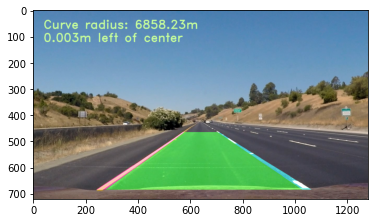

In [47]:
processed_img = image_pipeline(test_images[0])
plt.imshow(processed_img)

In [48]:
# add python dependencies for video editing
from moviepy.editor import VideoFileClip
# video widgw for HTML video player
from IPython.display import HTML
# Test for project video
video_output1 = 'project_video_output.mp4'
video_input1 = VideoFileClip('project_video.mp4')
processed_video = video_input1.fl_image(image_pipeline)
%time processed_video.write_videofile(video_output1, audio=False)

t:   0%|                                                                    | 2/1260 [00:00<01:34, 13.37it/s, now=None]

Moviepy - Building video project_video_output.mp4.
Moviepy - Writing video project_video_output.mp4



Moviepy - Done !
Moviepy - video ready project_video_output.mp4
Wall time: 4min 2s
